# PCA analysis of predictiveness of DEG for gender

### FDR 0.05 is noisy, adjusting results for FDR < 0.01 

In [1]:
#load required packages
import functools
import numpy as np
import pandas as pd
from plotnine import *
from scipy.stats import linregress
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from warnings import filterwarnings
from matplotlib.cbook import mplDeprecation

In [2]:
filterwarnings("ignore",category=mplDeprecation)
filterwarnings('ignore', category=UserWarning, module='plotnine.*')
filterwarnings('ignore', category=DeprecationWarning, module='plotnine.*')

## Configuration and functions

In [3]:
feature = 'genes'
config = {
    'deg_file': '../../_m/%s/diffExpr_maleVfemale_full.txt' % feature,
    'res_file': '../../_m/%s/residualized_expression.tsv' % feature,
    'pheno_file': '/ceph/projects/v3_phase3_paper/inputs/phenotypes/_m/dlpfc_phenotypes.csv',
    'deg_autosomal': '../../metrics_summary/_m/autosomal_DEG.csv',
}

In [4]:
@functools.lru_cache()
def get_deg():
    ''' Take DE genes obtained from limma-voom pipeline.
    '''
    deg = pd.read_csv(config['deg_file'], 
                      sep='\t').sort_values('adj.P.Val')
    return deg[(deg['adj.P.Val'] < 0.01)]


@functools.lru_cache()
def get_autosomal_deg():
    ''' Take autosomal only DE genes.'''
    deg = pd.read_csv(config['deg_autosomal'], 
                      index_col=0).sort_values('adj.P.Val')
    return deg[(deg['adj.P.Val'] < 0.01)]


@functools.lru_cache()
def get_residualized():
    '''Load residualization file.
    '''
    return pd.read_csv(config['res_file'], sep='\t', 
                       index_col=0).transpose()


@functools.lru_cache()
def get_deg_res_df(num):
    de_df = get_deg()
    res_df = get_residualized()
    if num == 0:
        geneList = np.array(de_df.index)
    else:
        geneList = np.array(de_df.head(num).index)
    return res_df[geneList]


@functools.lru_cache()
def get_autosomal_deg_res_df(num):
    de_df = get_autosomal_deg()
    res_df = get_residualized()
    if num == 0:
        geneList = np.array(de_df.index)
    else:
        geneList = np.array(de_df.head(num).index)
    return res_df[geneList]


@functools.lru_cache()
def get_pheno_data():
    return pd.read_csv(config['pheno_file'], index_col=0)

In [5]:
def get_explained_variance(df):
    x = StandardScaler().fit_transform(df)
    pca = PCA(n_components=2).fit(x)
    pc1 = pca.explained_variance_ratio_[0]
    pc2 = pca.explained_variance_ratio_[1]
    print("Explained Variance\nPC1:\t%0.5f\nPC2:\t%0.5f" % (pc1, pc2))
    
    
def cal_pca(df):
    x = StandardScaler().fit_transform(df)
    pca = PCA(n_components=2).fit_transform(x)
    return pd.DataFrame(data=pca, columns=['PC1', 'PC2'], index=df.index)


def get_pca_df(num, deg_fnc):
    '''
    num: refers to how many genes we want to include
    if 0, look at all genes, if not 0, look at only those specified genes
    new_pheno: this is the correct size of samples using the the first two columns of residualized expression
      - the residualized expression data frame, has the correct samples (dropping qSV samples included in pheno)
      - output new_pheno shape row numbers should be the same as res_df row numbers
    '''
    expr_res = deg_fnc(num)
    pheno_df = get_pheno_data()
    new_pheno = pheno_df.merge(expr_res.iloc[:, 0:1], right_index=True, # Generate pheno data frame with correct samples
                               left_index=True).drop(expr_res.iloc[:, 0:1].columns, axis=1)
    principalDf = cal_pca(expr_res)
    get_explained_variance(expr_res)
    return pd.concat([principalDf, new_pheno], axis = 1)


def calculate_corr(xx, yy):
    '''This calculates R^2 correlation via linear regression:
         - used to calculate relationship between 2 arrays 
         - the arrays are principal components 1 or 2 (PC1, PC2) AND gender
         - calculated on a scale of 0 to 1 (with 0 being no correlation)
        Inputs: 
          x: array of Gender (converted to binary output)
          y: array of PC
        Outputs: 
          1. r2
          2. p-value, two-sided test 
            - whose null hypothesis is that two sets of data are uncorrelated
          3. slope (beta): directory of correlations
    '''
    slope, intercept, r_value, p_value, std_err = linregress(xx, yy)
    return slope, r_value, p_value

    
def corr_annotation(dft):
    xx = dft.Sex.cat.codes
    yy = dft.PC1
    zz = dft.PC2
    slope1, r_value1, p_value1 = calculate_corr(xx, yy)
    slope2, r_value2, p_value2 = calculate_corr(xx, zz)
    label = 'PC1 R2: %.2f\nP-value: %.2e' % (r_value1**2, p_value1)
    print('PC2 R2: %.4f Pval: %.3e' % (r_value2**2, p_value2))
    return label


In [6]:
def plot_corr_impl(num, deg_fnc):
    pca_df = get_pca_df(num, deg_fnc)
    pca_df['Sex'] = pca_df.Sex.astype('category').cat.rename_categories({'F': 'Female', 'M': 'Male'})
    title = '\n'.join([corr_annotation(pca_df)])
    pp = ggplot(pca_df, aes(x='PC1', y='PC2', color='Sex'))\
    + geom_point(alpha=0.75, size=4)\
    + theme_matplotlib()\
    + theme(axis_text_x=element_blank(), 
            axis_text_y=element_text(size=18), 
            axis_title=element_text(size=21), 
            plot_title=element_text(size=22),
            legend_text=element_text(size=16), 
            legend_title=element_blank(), 
            legend_position="bottom")
    pp += ggtitle(title)
    return pp


def plot_corr(num, deg_fnc):
    return plot_corr_impl(num, deg_fnc)


def save_plot(p, fn, width=7, height=7):
    '''Save plot as svg, png, and pdf with specific label and dimension.'''
    for ext in ['.svg', '.png', '.pdf']:
        p.save(fn+ext, width=width, height=height)


## All DEG

Explained Variance
PC1:	0.28696
PC2:	0.13908
PC2 R2: 0.3181 Pval: 3.338e-31


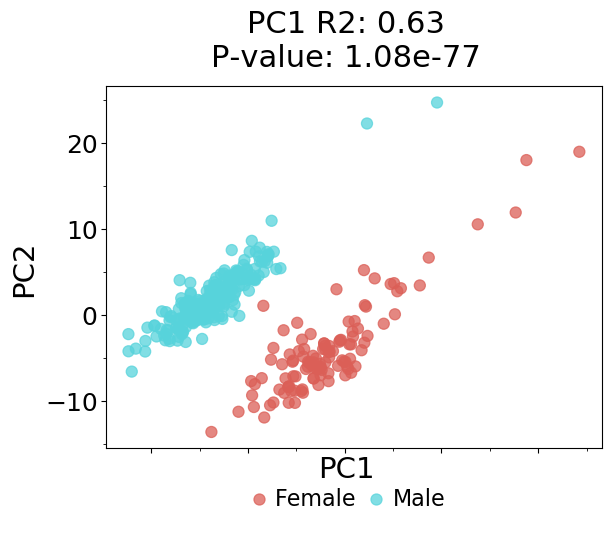

<ggplot: (8757626265224)>

In [7]:
pp = plot_corr(0, get_deg_res_df)
pp

Explained Variance
PC1:	0.92879
PC2:	0.01427
PC2 R2: 0.0052 Pval: 1.738e-01


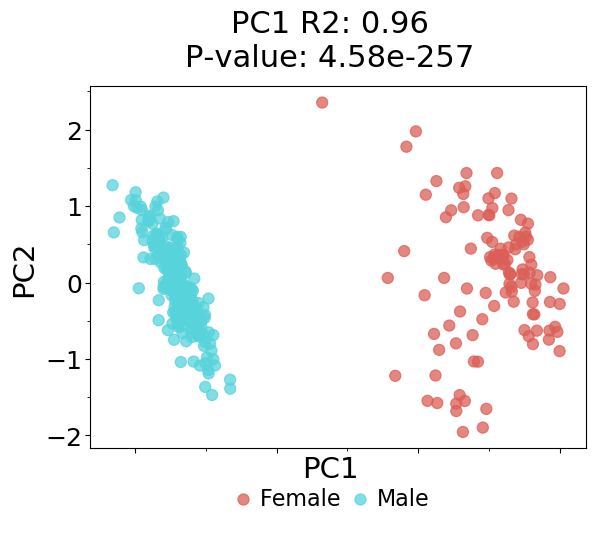

<ggplot: (8757626342894)>

In [8]:
qq = plot_corr(30, get_deg_res_df)
qq

Explained Variance
PC1:	0.98316
PC2:	0.00512
PC2 R2: 0.0013 Pval: 5.049e-01


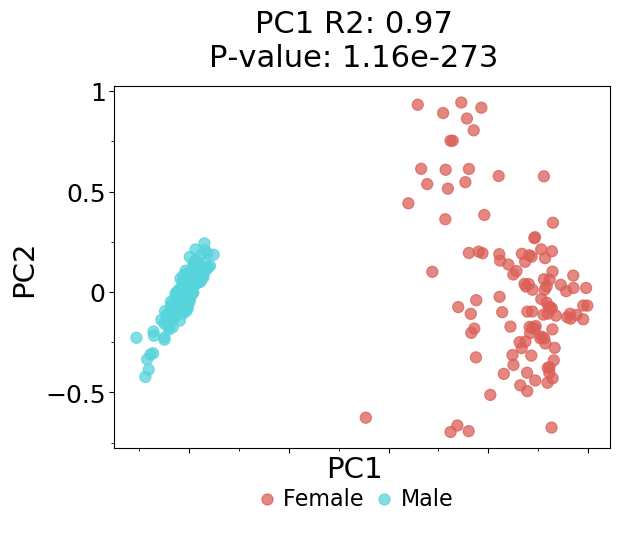

<ggplot: (8757626345939)>

In [9]:
ww = plot_corr(10, get_deg_res_df)
ww

In [12]:
save_plot(pp, 'deg_pca_all')
save_plot(qq, 'deg_pca_top30')
save_plot(ww, 'deg_pca_top10')

## Autosomal DEG

Explained Variance
PC1:	0.26685
PC2:	0.05910
PC2 R2: 0.0821 Pval: 3.934e-08


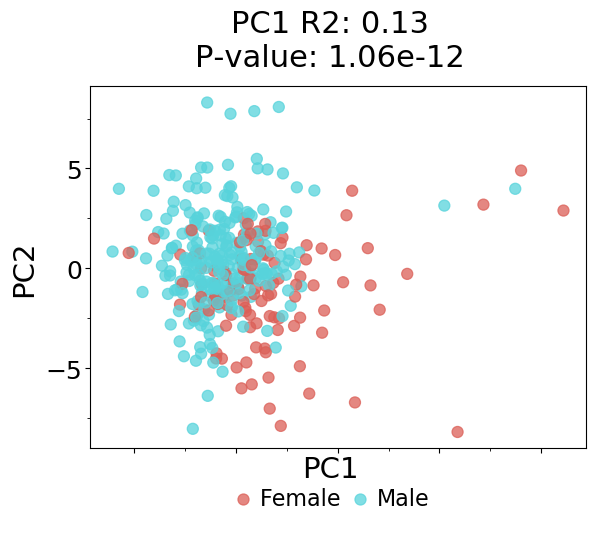

<ggplot: (8757626322776)>

In [10]:
pp = plot_corr(0, get_autosomal_deg_res_df)
pp

Explained Variance
PC1:	0.18963
PC2:	0.12873
PC2 R2: 0.0087 Pval: 7.896e-02


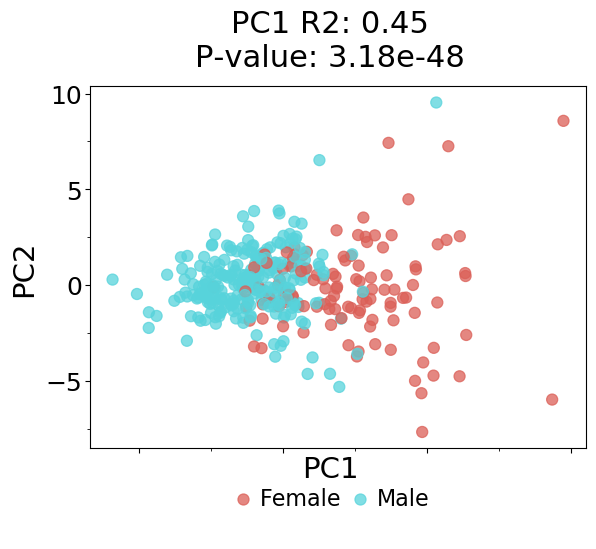

<ggplot: (8757626299332)>

In [11]:
qq = plot_corr(30, get_autosomal_deg_res_df)
qq

Explained Variance
PC1:	0.39297
PC2:	0.15676
PC2 R2: 0.1135 Pval: 7.142e-11


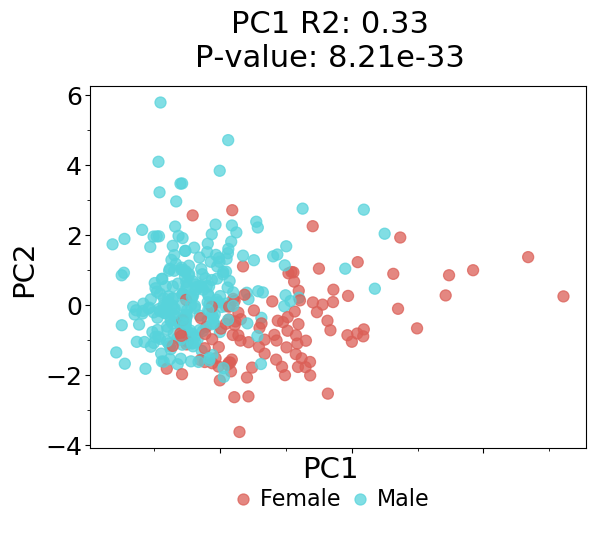

<ggplot: (8757626205980)>
Explained Variance
PC1:	0.31333
PC2:	0.13940
PC2 R2: 0.0254 Pval: 2.604e-03


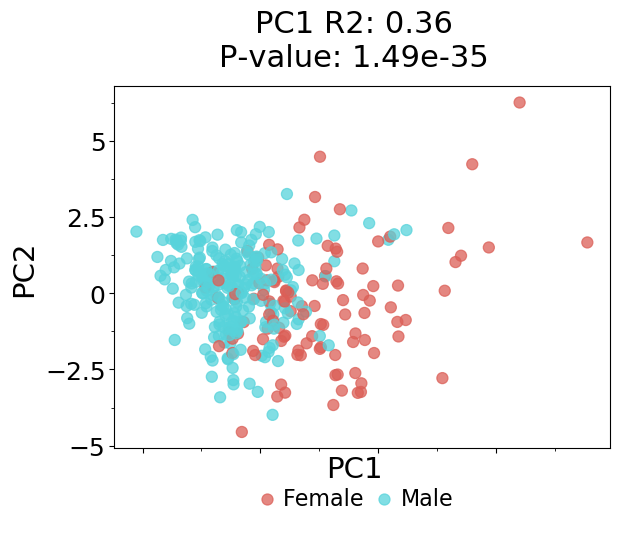

<ggplot: (8757626305768)>
Explained Variance
PC1:	0.24975
PC2:	0.13177
PC2 R2: 0.0068 Pval: 1.211e-01


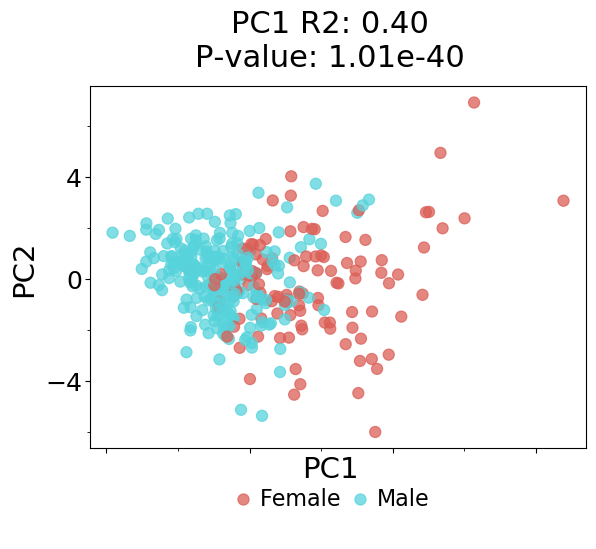

<ggplot: (8757626206145)>
Explained Variance
PC1:	0.20758
PC2:	0.12243
PC2 R2: 0.0279 Pval: 1.578e-03


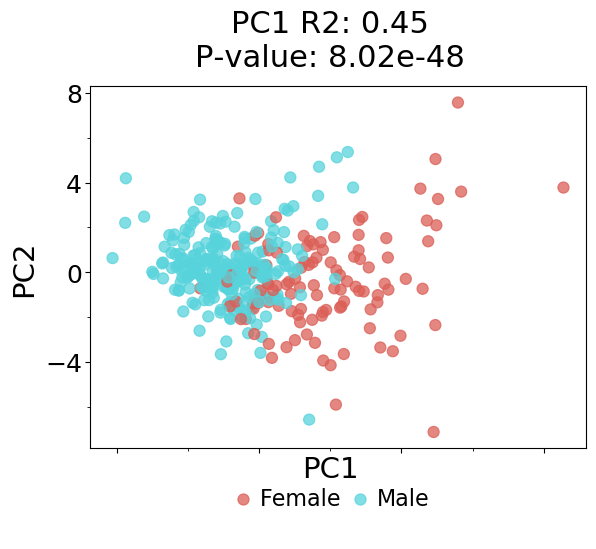

<ggplot: (8757626345900)>
Explained Variance
PC1:	0.18963
PC2:	0.12873
PC2 R2: 0.0087 Pval: 7.896e-02


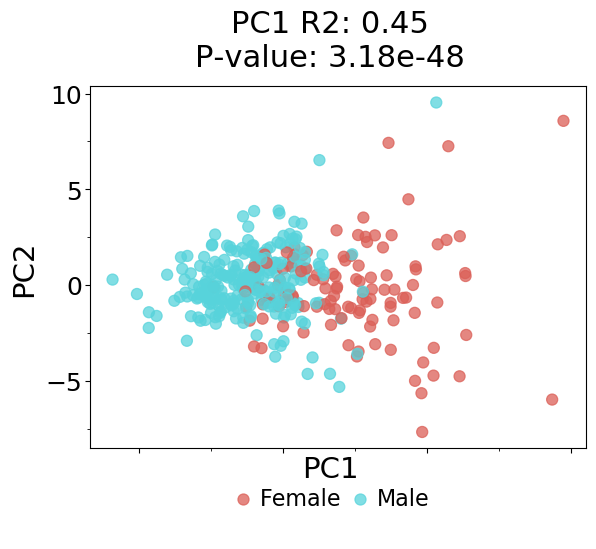

<ggplot: (8757626247256)>
Explained Variance
PC1:	0.17382
PC2:	0.11586
PC2 R2: 0.0220 Pval: 5.117e-03


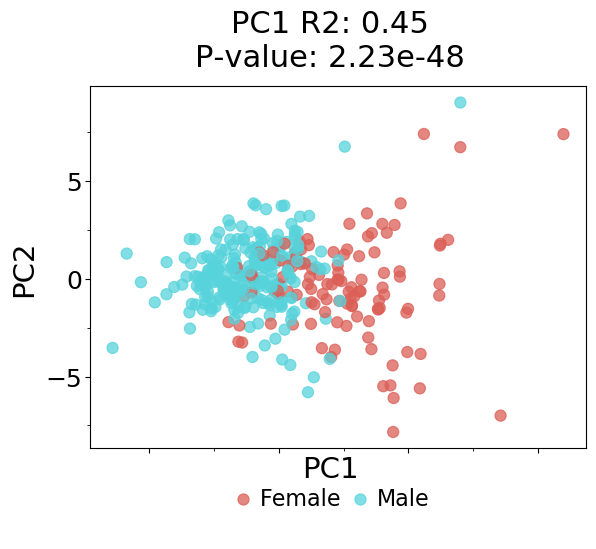

<ggplot: (8757626079115)>
Explained Variance
PC1:	0.18042
PC2:	0.10804
PC2 R2: 0.1021 Pval: 7.221e-10


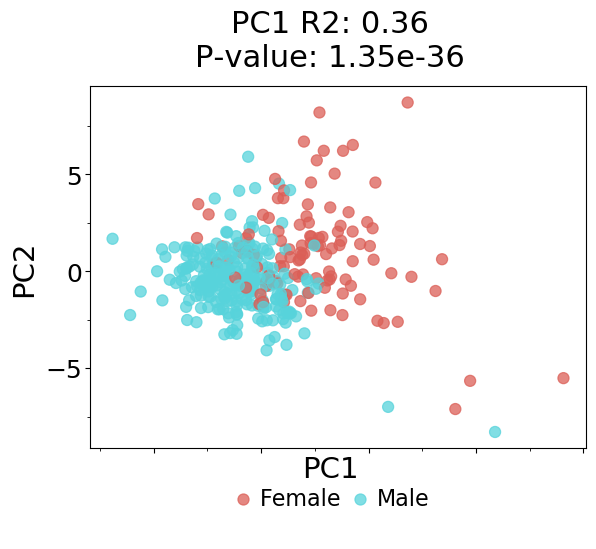

<ggplot: (8757625492146)>
Explained Variance
PC1:	0.18286
PC2:	0.10246
PC2 R2: 0.1372 Pval: 5.515e-13


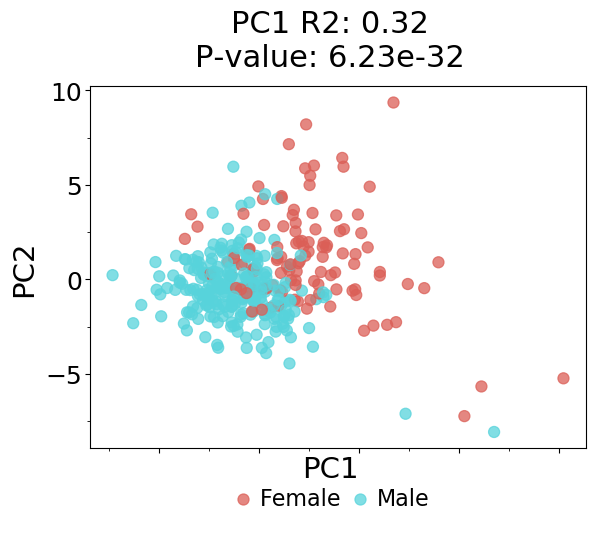

<ggplot: (8757625498670)>


In [12]:
for num in range(10, 50, 5):
    print(plot_corr(num, get_autosomal_deg_res_df))

Explained Variance
PC1:	0.39297
PC2:	0.15676
PC2 R2: 0.1135 Pval: 7.142e-11


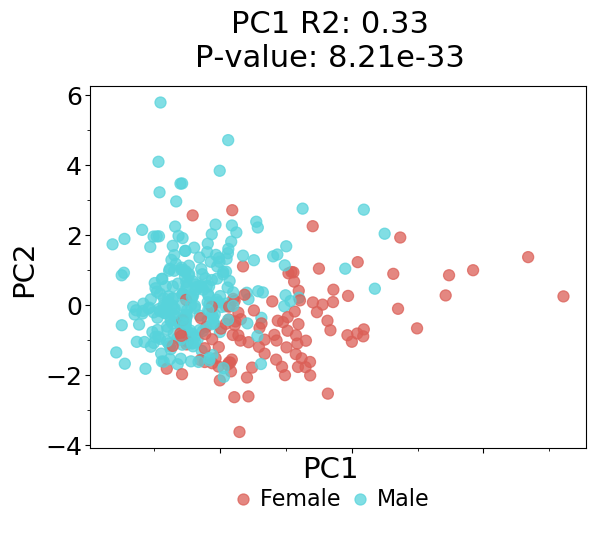

<ggplot: (8757625381958)>

In [15]:
ww = plot_corr(10, get_autosomal_deg_res_df)
ww

In [31]:
save_plot(pp, 'autosomal_deg_pca_all')
save_plot(qq, 'autosomal_deg_pca_top30')
save_plot(ww, 'autosomal_deg_pca_top10')